In [1]:
import os
import sys
import json
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt
from IPython.display import Image

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM

from DiffNet.datasets.parametric.images import ImageIMBack
from e1_complex_immersed_background import Poisson

from DiffNet.datasets.single_instances.images import ImageIMBack as ImageIMBackSingleInstance
from e7_complex_immersed_background_single_instance import Poisson as PoissonSingleInstance

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42
Global seed set to 42


In [2]:
def run_single_instance(input_nu_filename):
    filename = input_nu_filename # 'world_map.jpg'
    dataset = ImageIMBackSingleInstance(filename, domain_size=256)
    u_tensor = np.ones_like(dataset.domain)
    network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
    basecase = PoissonSingleInstance(network, dataset, batch_size=1, domain_size=256)

    # ------------------------
    # 1 INIT TRAINER
    # ------------------------
    logger = pl.loggers.TensorBoardLogger('.', name="cib_single")
    csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

    early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
        min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
    checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
        dirpath=logger.log_dir, filename='{epoch}-{step}',
        mode='min', save_last=True)

    trainer = Trainer(gpus=[0],callbacks=[early_stopping],
        checkpoint_callback=checkpoint, logger=[logger,csv_logger],
        max_epochs=5, deterministic=True, profiler='simple')

    trainer.fit(basecase)
    torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))
    
    inputs, forcing = basecase.dataset[0]
    nu, f, u = basecase.do_query(inputs, forcing)
    return nu, f, u

In [3]:
def query_plot_contours_and_save(dirpath,nu,f,u, saveid=None):
    outfilename = os.path.join(dirpath, 'query.png')
    if saveid != None:
        outfilename = os.path.join(dirpath, 'query_'+str(saveid)+'.png')
    # plotting
    num_query = nu.shape[0]
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2.4*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        kp = nu[idx,:,:]
        up = u[idx,:,:]

        im0 = axs[idx][0].imshow(kp,cmap='jet')
        fig.colorbar(im0, ax=axs[idx,0])
        im1 = axs[idx][1].imshow(up,cmap='jet')
        fig.colorbar(im1, ax=axs[idx,1]) 
    # plt.savefig(outfilename)
    # plt.close('all')
    plt.show()

def query_plot_contours_and_save_SINGLEROW(dirpath,nu,f,u, saveid=None):
    outfilename = os.path.join(dirpath, 'query.png')
    if saveid != None:
        outfilename = os.path.join(dirpath, 'query_'+str(saveid)+'.png')
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2.4*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax in axs:        
        ax.set_xticks([])
        ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        kp = nu[:,:]
        up = u[:,:]

        im0 = axs[0].imshow(kp,cmap='jet')
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(up,cmap='jet')
        fig.colorbar(im1, ax=axs[1]) 
    # plt.savefig(outfilename)
    # plt.close('all')
    plt.show()

In [77]:
dirname = './complex_immersed_background/version_29/selected_query_inputs'
case_dir = './complex_immersed_background/version_29'
query_out_path = os.path.join(case_dir, 'selected_query_outputs')
if not os.path.exists(query_out_path):
    os.makedirs(query_out_path)
dataset = ImageIMBack(dirname, domain_size=256)
#network = GoodNetwork(in_channels=2, out_channels=1, in_dim=64, out_dim=64)
network = torch.load(os.path.join(case_dir, 'network.pt'))
basecase = Poisson(network, dataset, batch_size=16, domain_size=256)

nsample = len(basecase.dataset)
print("nsample = ", nsample)

nsample =  7


In [78]:
for i in range(nsample//10+1):
    id0 = 10*i
    id1 = id0+10
    if id1 > nsample:
        id1 = nsample
        
    # core query code
    inputs, forcing = basecase.dataset[id0:id1]
    nu_par_list, f_par_list, u_par_list = basecase.do_query(inputs, forcing)
    # query_plot_contours_and_save(query_out_path, nu_par_list, f_par_list, u_par_list, i)

In [79]:
# Image(filename=os.path.join(query_out_path,'query.png')) 

In [80]:
query_input_filenames = os.listdir(dirname)
nu_single_list = []
u_single_list = []
f_single_list = []
for fname in query_input_filenames:
    filename = os.path.join(dirname, fname)
    file, ext = os.path.splitext(filename)
    if ext in ['.png', '.jpg', '.bmp', '.tiff']:
        nu, f, u = run_single_instance(filename)
        nu_single_list.append(nu)
        f_single_list.append(f)
        u_single_list.append(u)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_15 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 65.5 K
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
65.5 K    Trainable params
96        Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 51.08it/s, loss=30.1, v_num=5_15]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  14.424         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.8747         	|5              	|  14.374         	|  99.65          	|
run_training_batch                 	|  0.02417        	|500            	|  12.085         	|  83.782         	|
optimizer_step_and_closure_0       	|  0.023925       	|500            	|  11.962         	|  82.934         	|
training_step_and_backward         	|  0.0066116      	|873            	|  5.772          	|  40.016         	|
backward                           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_16 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 65.5 K
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
65.5 K    Trainable params
96        Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 50.76it/s, loss=28.7, v_num=6_16]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  14.723         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.9358         	|5              	|  14.679         	|  99.7           	|
run_training_batch                 	|  0.024778       	|500            	|  12.389         	|  84.145         	|
optimizer_step_and_closure_0       	|  0.024532       	|500            	|  12.266         	|  83.311         	|
training_step_and_backward         	|  0.0066997      	|874            	|  5.8555         	|  39.77          	|
backward                           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_17 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 65.5 K
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
65.5 K    Trainable params
96        Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 48.54it/s, loss=34.5, v_num=7_17]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  13.945         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.7806         	|5              	|  13.903         	|  99.7           	|
run_training_batch                 	|  0.023261       	|500            	|  11.63          	|  83.403         	|
optimizer_step_and_closure_0       	|  0.023017       	|500            	|  11.508         	|  82.528         	|
training_step_and_backward         	|  0.0067191      	|841            	|  5.6507         	|  40.522         	|
backward                           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_18 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 65.5 K
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
65.5 K    Trainable params
96        Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 51.07it/s, loss=46.6, v_num=8_18]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  13.326         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.6564         	|5              	|  13.282         	|  99.668         	|
run_training_batch                 	|  0.022002       	|500            	|  11.001         	|  82.552         	|
optimizer_step_and_closure_0       	|  0.02175        	|500            	|  10.875         	|  81.607         	|
training_step_and_backward         	|  0.0066019      	|806            	|  5.3211         	|  39.93          	|
backward                           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_19 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 65.5 K
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
65.5 K    Trainable params
96        Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 50.95it/s, loss=27.2, v_num=9_19]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  14.352         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.8617         	|5              	|  14.309         	|  99.697         	|
run_training_batch                 	|  0.024023       	|500            	|  12.012         	|  83.692         	|
optimizer_step_and_closure_0       	|  0.023774       	|500            	|  11.887         	|  82.824         	|
training_step_and_backward         	|  0.0066195      	|869            	|  5.7523         	|  40.08          	|
backward                           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_20 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 65.5 K
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
65.5 K    Trainable params
96        Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 50.15it/s, loss=32.5, v_num=0_20]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  14.531         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.8978         	|5              	|  14.489         	|  99.706         	|
run_training_batch                 	|  0.02436        	|500            	|  12.18          	|  83.82          	|
optimizer_step_and_closure_0       	|  0.024109       	|500            	|  12.054         	|  82.954         	|
training_step_and_backward         	|  0.0067378      	|900            	|  6.064          	|  41.73          	|
backward                           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./cib_single/version_21 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 65.5 K
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
65.5 K    Trainable params
96        Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 51.15it/s, loss=34, v_num=1_21] 

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  14.0           	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  2.791          	|5              	|  13.955         	|  99.682         	|
run_training_batch                 	|  0.023303       	|500            	|  11.652         	|  83.228         	|
optimizer_step_and_closure_0       	|  0.023058       	|500            	|  11.529         	|  82.353         	|
training_step_and_backward         	|  0.0066057      	|856            	|  5.6545         	|  40.39          	|
backward                           

In [81]:
# for nu, u in zip(nu_single_list, u_single_list):
    # query_plot_contours_and_save_SINGLEROW('',nu,f,u)

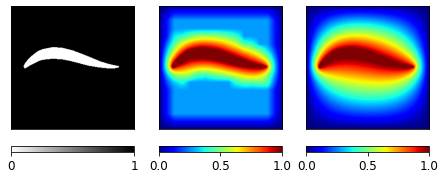

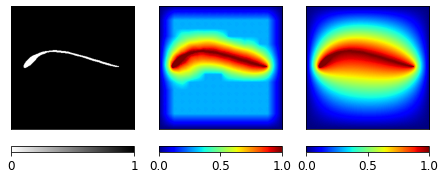

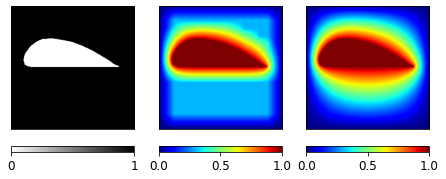

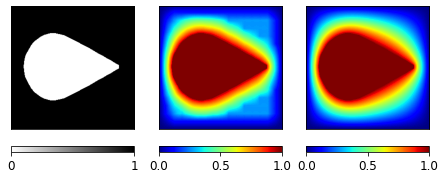

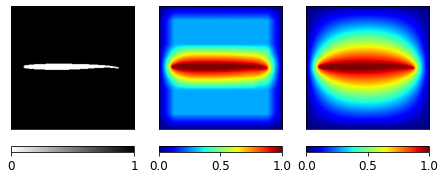

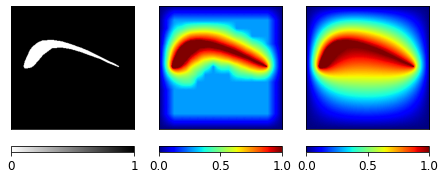

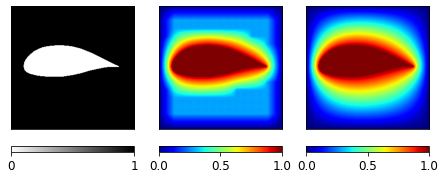

In [97]:
for i in range(nsample):
    # core query code
    nu = nu_par_list[i]
    u_par = u_par_list[i]
    u_single = u_single_list[i]
    
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 3
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2.5*plt_num_col,3*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
#     fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2*plt_num_col,2*plt_num_row),
#                         subplot_kw={'aspect': 'auto'},sharey=True)
    #fig.tight_layout()
    for ax in axs:        
        ax.set_xticks([])
        ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        im0 = axs[0].imshow(nu,cmap='gray_r')
        cb = fig.colorbar(im0, ax=axs[0], fraction=0.04, pad=0.1,orientation="horizontal")
        cb.set_ticks([0,1])
        cb.set_ticklabels([0,1])
        im1 = axs[1].imshow(u_par,cmap='jet')
        fig.colorbar(im1, ax=axs[1], fraction=0.04, pad=0.1,orientation="horizontal") 
        im2 = axs[2].imshow(u_single,cmap='jet')
        fig.colorbar(im2, ax=axs[2], fraction=0.04, pad=0.1,orientation="horizontal") 
    # plt.close('all')
#     plt.tight_layout()
    plt.savefig(os.path.join(query_out_path,'q_'+str(i)+'.png'))
    plt.show()    

In [100]:
aa,bb=basecase.dataset[0]

In [101]:
aa.shape

torch.Size([3, 256, 256])

In [102]:
bb.shape

torch.Size([1, 256, 256])

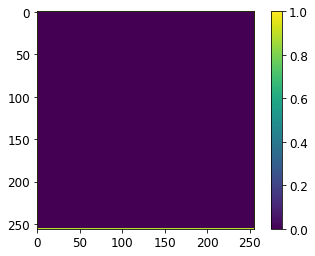

In [106]:
plt.imshow(aa[2])
plt.colorbar()